In [1]:
!python -V

Python 3.9.13


In [2]:
# !pip install lightgbm

### Imports

In [3]:
import pickle
import warnings
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [4]:
# set float display format to 3 decimal places
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [5]:
# ignore warnings from sklearn and other third party libraries
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn

**MLflow setup**

In [6]:
# mlflow setup  for experiment tracking
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("wallet-hub-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='wallet-hub-experiment', tags={}>

In [7]:
data_path = "data/dataset_00_with_header.csv"

In [8]:
df = pd.read_csv(data_path)

In [9]:
df.shape

(100000, 305)

### Data Cleaning

In [10]:
# dataframe for percentage of missing values
null_df = df.isnull().sum().to_frame('nulls')
null_df = null_df.sort_values(by=['nulls'], ascending=False )
null_df['percent_nulls'] = null_df['nulls']/df.shape[0]

In [11]:
null_df.head(20)

,nulls,percent_nulls
x242,93339,0.933
x295,86533,0.865
x304,81875,0.819
x098,80681,0.807
x155,79051,0.791
x259,77432,0.774
x255,76913,0.769
x256,76913,0.769
x257,76913,0.769
x302,73069,0.731


In [12]:
# more than 50 percent null 
null_df = null_df[null_df['percent_nulls'] > 0.50]

In [13]:
null_columns = list(null_df.index)

In [14]:
df = df.drop(null_columns, axis=1)

In [15]:
df.shape

(100000, 286)

**Remove columns with too many zeros**

In [16]:
# percentage of zero values dataframe
zeros_df = df[df == 0].count().to_frame('zeros_count')
zeros_df = zeros_df.sort_values(by=['zeros_count'], ascending=False)
zeros_df['percent_zeros'] = zeros_df['zeros_count']/df.shape[0]
zeros_df.head()

,zeros_count,percent_zeros
x067,100000,1.000
x096,100000,1.000
x094,100000,1.000
x095,100000,1.000
x060,99996,1.000


In [17]:
# more than 79 percent zero values
zeros_df = zeros_df[zeros_df['percent_zeros'] > 0.79]

In [18]:
zeros_columns = list(zeros_df.index)

In [19]:
# drop extreme zero values columns
df = df.drop(columns=zeros_columns)

In [20]:
df.shape

(100000, 129)

In [21]:
df = df.fillna(df.mean())

### Data Exploration

**target variable**

In [22]:
df['y'].describe()

count   100000.000
mean       619.198
std        118.462
min        300.000
25%        524.000
50%        599.000
75%        720.000
max        839.000
Name: y, dtype: float64

mu = 619.198 , sigma = 118.461


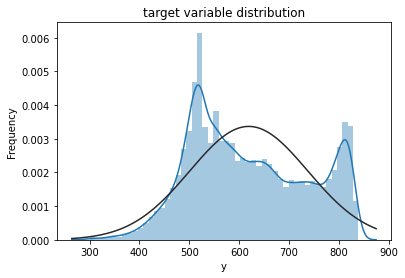

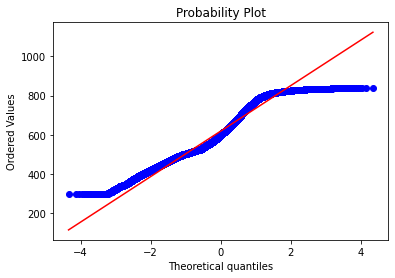

In [23]:
sns.distplot(df['y'], fit=norm)

(mu, sigma) = norm.fit(df['y'])
print(f"mu = {mu:.3f} , sigma = {sigma:.3f}")
plt.ylabel('Frequency')
plt.title('target variable distribution')

fig = plt.figure()
res = probplot(df['y'], plot=plt)

### Feature Selection

*Uncomment and execute only on better compute because it takes a lot of time*

In [24]:
target = 'y'
features = df.columns[df.columns != target]

In [25]:
# X = df[features].values
# y = df[target].values

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=0)

In [27]:
# random forest for feature importances - takes a long time to run
# forest_fs = RandomForestRegressor(n_estimators=1000, random_state=1)

In [28]:
# forest_fs.fit(X_train, y_train)

#### Assessing feature importances

In [29]:
# importances = forest_fs.feature_importances_
# indices = np.argsort(importances)[::-1]

**Top 30 features**

In [30]:
# top_10_features = []
# for f in range(10):
#   top_10_features.append(features[indices[f]])
#   print("%2d) %-*s %f" % (f + 1, 30,
#                           features[indices[f]],
#                           importances[indices[f]]))

**Here are the top 10 discriminative features**

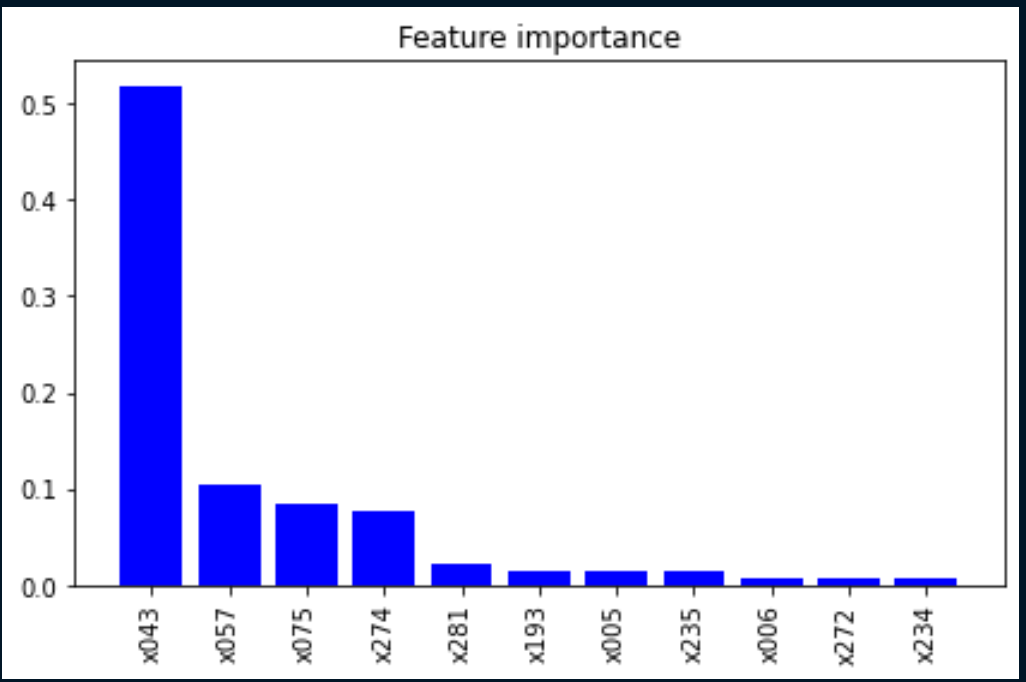

In [31]:
from IPython.display import Image
Image('feature_importance.png')

In [32]:
top_10_features = ['x043',
 'x057',
 'x075',
 'x274',
 'x281',
 'x193',
 'x005',
 'x235',
 'x006',
 'x272']

 we can safely say that *x043, x057, x075, x274, x281, x193, x005, x235* are the most discriminative features of the dataset based on the average impurities of 1000 decision trees                       

**Lets plot the top 10 features with their importances**

In [33]:
# plt.title('Feature importance')
# plt.bar(range(11), importances[indices[:11]], color='blue', align='center')
# plt.xticks(range(11), features[indices[:11]], rotation=90)
# plt.xlim([-1, 11])
# plt.tight_layout()
# plt.show()

### Modelling

In [34]:
X = df[features].values
y = df[target].values

In [35]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [36]:
# train validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)


In [37]:
X_train.shape

(81000, 128)

In [38]:
X_val.shape

(9000, 128)

**Functions**

In [39]:
def calculate_accuracy(y_true, y_pred):
    """summary:
         function that calculates the accuracy of a model. 
         Based on the mean absolute deviation of predictions from the actual values not greater than 3

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    acc_threshold = 3 # as stated in the requirements
    diff_pred = np.abs(y_true - y_pred) # absolute difference
    accuracy = np.count_nonzero(diff_pred <= acc_threshold) / len(diff_pred) # accuracy 
    return accuracy

In [40]:
def log_model_artifact(model:object, model_type:str):
    """
    summary: log model artifacts to mlflow and save locally

    Args:
        model (object): model object
        model_type (str): model type
    """
    with open(f'models/{model_type}.pkl', 'wb') as f:
        pickle.dump(model, f)
    mlflow.log_artifact(f'models/{model_type}.pkl', artifact_path='models_mlflow')

In [41]:
def train(model:object, model_type:str, model_params:dict, save_model=False) -> object:
    """
    summary: 
        train model based on hyperopt best params. 
        If save_model is True, then save the model to disk.
        Also log metrics on mlflow.

    Args:
        model (object): model instance to train. can be none for xgb and lgb models
        model_type (str): model type.("xgboost", "lightgbm", "lasso", "elastic-net")
        model_params (dict): model parameters
        save_model (bool, optional): flag to save and log model or not. Defaults to False.

    Returns:
        object: trained model
    """
    if model_type not in ("xgboost", "lightgbm", "lasso", "elastic-net"):
        raise ValueError("model_type must be one of xgboost, lightgbm, lasso, ElasticNet")
        
    # mlflow experiment tracking context
    with mlflow.start_run():
        mlflow.set_tag("model", model_type)
        mlflow.log_params(model_params)

        if model_type == "xgboost" and model == None:
            model = xgb.train(
                params=model_params,
                dtrain=xgb.DMatrix(X_train, label=y_train),
                num_boost_round=1000,
                evals=[(xgb.DMatrix(X_val, label=y_val), 'validation')],
                early_stopping_rounds=50)
        elif model_type == "lightgbm" and model == None:
            model = lgb.train(
                params=model_params,
                train_set=lgb.Dataset(X_train, label=y_train, params={"max_bin": 50}),
                valid_sets=[lgb.Dataset(X_val, label=y_val)],
                num_boost_round=1000,
                early_stopping_rounds=50)
        else:
            model.fit(X_train, y_train)

        
        if model_type == "xgboost":
            y_pred = model.predict(xgb.DMatrix(X_val))
        else:
            y_pred = model.predict(X_val)

        # calculate  model metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        accuracy = calculate_accuracy(y_val, y_pred)

        metrics = {
            "rmse": rmse,
            "r2": r2,
            "accuracy": accuracy
        }

        mlflow.log_metrics(metrics)

    if save_model:
        log_model_artifact(model, model_type)
    
    mlflow.end_run()

    return model

In [42]:
def plot_residual_plot(y_train_pred, y_test_pred):
    """
    summary: 
        visualize residual plot. Helps to visualize the model performance.
        Helps to indentify outliers in the data;
             represented by large deviations from the centre line.

    Args:
        y_train_pred (ndarray): y_train predictions
        y_test_pred (ndarray): y_test predictions
    """
    x_max = np.max(
        [np.max(y_train_pred), np.max(y_test_pred)])

    x_min = np.min(
        [np.min(y_train_pred), np.min(y_test_pred)])

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(7,3), sharey=True)

    ax1.scatter(
        y_test_pred, y_test_pred - y_test,
        c='limegreen', marker='s',
        edgecolor='white',
        label= 'Test data')

    ax2.scatter(
        y_train_pred, y_train_pred - y_train,
        c='steelblue', marker='o',
        edgecolor='white',
        label= 'Training data')

    ax1.set_ylabel('Residuals')

    for ax in (ax1, ax2):
        ax.set_xlabel('predicted values')
        ax.legend(loc='upper left')
        ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,
                    color='black', lw=2)
    
    plt.tight_layout()
    plt.show()

In [43]:
# stop here

#### Lasso regression

In [44]:
lasso_params = { "alpha": 0.005 }
lasso = make_pipeline(
        RobustScaler(), 
        Lasso(alpha=lasso_params["alpha"], random_state=1))

model_lasso = train(lasso, 'lasso', lasso_params)

#### ElasticNet

In [45]:
enet_params = { "alpha": 0.005, "l1_ratio": 0.9 }
enet = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=enet_params['alpha'], l1_ratio=enet_params['l1_ratio'], random_state=3))

# train and load evaluation metric
model_enet= train(enet, 'elastic-net', enet_params, save_model=True)

#### XGBoost

**Tuning XGBoost with hyperopt**

In [46]:
# xgboost Dmatrix initialization
# train = xgb.DMatrix(X_train, label=y_train)
# valid = xgb.DMatrix(X_val, label=y_val)

In [47]:
def xgb_objective(params):
    """
    summary:
        objective function for xgboost hyperparameter tuning using hyperopt

    Args:
        params (dict): xgboost hyperparameters search space

    Returns:
        dict: model metric - rmse
    """
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        
        model_xgb = xgb.train(
            params=params,
            dtrain=xgb.DMatrix(X_train, label=y_train),
            num_boost_round=1000,
            evals=[(xgb.DMatrix(X_val, label=y_val), 'validation')],
            early_stopping_rounds=50,
        )
    
        
        y_pred = model_xgb.predict(valid)
        rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred))
        r2_xgb = r2_score(y_val, y_pred)


        mlflow.log_metric('rmse', rmse_xgb)
        mlflow.log_metric('r2', r2_xgb)
    
    return {'loss': rmse_xgb, 'status': STATUS_OK}

In [48]:
# xgb search space for hyperparameter tuning
xgb_search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 2000, 100)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'seed': 42
}

In [49]:
# xgb hyperopt search
best_result = fmin(
    fn=xgb_objective, # objective function
    space=xgb_search_space, # parameter search space
    algo=tpe.suggest, 
    max_evals=20, 
    trials=Trials())

In [50]:
# best params after tuning with 20 evaluations
xgboost_best_params = {
    "colsample_bytree": 0.5943780476579916,
    "learning_rate":	0.054120181998319354,
    "max_depth": 9,
    "min_child_weight":	12.47506339422273,
    "n_estimators":	1800,
    "reg_alpha":	0.017613900382780774,
    "reg_lambda":	0.003320031633641519,
    "seed":	42
    }

In [51]:
# retrain with best params
model_xgboost= train(None, 'xgboost', xgboost_best_params, save_model=True)

[21:00:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:596.21381
[1]	validation-rmse:564.14858
[2]	validation-rmse:533.82776
[3]	validation-rmse:505.13055
[4]	validation-rmse:477.96466
[5]	validation-rmse:452.28756
[6]	validation-rmse:428.02342
[7]	validation-rmse:405.06445
[8]	validation-rmse:383.33561
[9]	validation-rmse:362.80383
[10]	validation-rmse:343.40598
[11]	validation-rmse:325.07026
[12]	validation-rmse:307.70340
[13]	validation-rmse:291.30215
[14]	validation-rmse:275.78789
[15]	validation-rmse:261.13748
[16]	validation-rmse:247.27202
[17]	validation-rmse:234.16983


**Xgboost test evaluation**

In [52]:
y_pred_test = model_xgboost.predict(xgb.DMatrix(X_test))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
xgb_test_r2 = r2_score(y_test, y_pred_test)
xgb_test_accuracy = calculate_accuracy(y_test, y_pred_test)
print(f"xgboost test rmse: {xgb_test_rmse:.3f}")
print(f"xgboost test r2: {xgb_test_r2:.3f}")
print(f"xgboost test accuracy: {xgb_test_accuracy:.3f}")

xgboost test rmse: 27.094
xgboost test r2: 0.948
xgboost test accuracy: 0.152


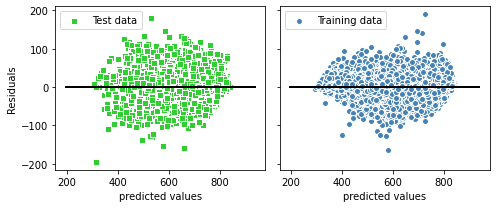

In [53]:
y_pred_train = model_xgboost.predict(xgb.DMatrix(X_train))
plot_residual_plot(y_pred_train, y_pred_test)

#### LightGBM

**Tune LightGBM with Hyperopt**

In [54]:
# lightgbm dataset initialization
light_train = lgb.Dataset(X_train, label=y_train, params={"max_bin": 50})
light_valid = lgb.Dataset(X_val, label=y_val)

In [55]:
# lightgbm hyperopt objective function
def lgb_objective(params):
    """
    summary:
        objective function for lightgbm hyperparameter tuning using hyperopt

    Args:
        params (dict): lightgbm hyperparameters search space

    Returns:
        dict: model metric - rmse
    """
    with mlflow.start_run():
        mlflow.set_tag('model', 'lightgbm')
        mlflow.log_params(params)

        model_lgb = lgb.train(
            params=params,
            train_set=light_train,
            num_boost_round=1000,
            valid_sets=light_valid,
            early_stopping_rounds=50
        )

        y_pred = model_lgb.predict(X_val)
        rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred))
        r2_lgbm = r2_score(y_val, y_pred)
        mlflow.log_metric('rmse', rmse_lgbm)
        mlflow.log_metric('r2', r2_lgbm)
    
    return {'loss': rmse_lgbm, 'status': STATUS_OK}

In [56]:
# lightgbm search space for hyperparameter tuning
lgb_search_space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 8, 128, 2)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'min_data_in_leaf': scope.int(hp.qloguniform('min_data_leaf', 0, 6, 1)),
    'verbose': -1,
    'seed': 42,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'objective': 'regression',
    # 'max_bin': 55,

}

In [57]:
# lgb hyperopt search
lgb_best_result = fmin(
    fn=lgb_objective, 
    space=lgb_search_space, 
    algo=tpe.suggest, 
    max_evals=20, 
    trials=Trials())

In [58]:
# best params after tuning with 20 evaluations
lgb_best_params = {
        "colsample_bytree": 0.5498070317107652,
        "learning_rate":	0.03,
        "num_leaves": 92,
        "objective": "regression",
        "n_estimators": 2200,
        "bagging_fraction": 0.8,
        "min_data_in_leaf":	6,
        "seed":	42}
    

In [59]:
# retrain with best params
model_lgb= train(None, 'lightgbm', lgb_best_params, save_model=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4211
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 128
[LightGBM] [Info] Start training from score 619.102691
[1]	valid_0's l2: 13190.2
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 12532.3
[3]	valid_0's l2: 11916.7
[4]	valid_0's l2: 11318.4
[5]	valid_0's l2: 10756.7
[6]	valid_0's l2: 10227.9
[7]	valid_0's l2: 9739.96
[8]	valid_0's l2: 9272.97
[9]	valid_0's l2: 8834.22
[10]	valid_0's l2: 8416.66
[11]	valid_0's l2: 8022.52
[12]	valid_0's l2: 7653.27
[13]	valid_0's l2: 7306.43
[14]	valid_0's l2: 6975.09
[15]	valid_0's l2: 6653.79
[16]	valid_0's l2: 6354.06
[17]	valid_0's l2: 6073.2
[18]	valid_0's l2: 5802.54
[19]	valid_0's l2: 5556.93
[20]	valid_0's l2: 5315.

In [60]:
y_pred_test = model_lgb.predict(X_test)
lgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
lgb_test_r2 = r2_score(y_test, y_pred_test)
lgb_test_accuracy = calculate_accuracy(y_test, y_pred_test)
print(f"lgb test rmse: {lgb_test_rmse:.3f}")
print(f"lgb test r2: {lgb_test_r2:.3f}")
print(f"lgb test accuracy: {lgb_test_accuracy:.3f}")

lgb test rmse: 26.801
lgb test r2: 0.949
lgb test accuracy: 0.142


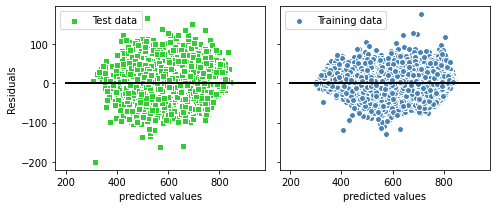

In [61]:
y_pred_train = model_lgb.predict(X_train)
plot_residual_plot(y_pred_train, y_pred_test)

### Train on selected features

*Uncomment and run only on better compute to slow to run*

In [62]:
X = df[top_10_features].values
y = df['y'].values

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [64]:
X_train.shape

(90000, 10)

In [65]:
# train validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

In [66]:
X_val.shape

(9000, 10)

In [67]:
# retrain with top 10 features and best params
model_xgboost_selected= train(None, 'xgboost', xgboost_best_params, save_model=True)

[21:04:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:596.20649
[1]	validation-rmse:564.18294
[2]	validation-rmse:534.00725
[3]	validation-rmse:505.43856
[4]	validation-rmse:478.39031
[5]	validation-rmse:452.84661
[6]	validation-rmse:428.65280
[7]	validation-rmse:405.74066
[8]	validation-rmse:384.07129
[9]	validation-rmse:363.59624
[10]	validation-rmse:344.20444
[11]	validation-rmse:325.98029
[12]	validation-rmse:308.71011
[13]	validation-rmse:292.41089
[14]	validation-rmse:276.92951
[15]	validation-rmse:262.34909
[16]	validation-rmse:248.54199
[17]	validation-rmse:235.48456


**Test Evaluation**

In [68]:
y_pred = model_xgboost_selected.predict(xgb.DMatrix(X_test))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_test_r2 = r2_score(y_test, y_pred)
xgb_test_accuracy = calculate_accuracy(y_test, y_pred)
print(f"xgboost test rmse: {xgb_test_rmse:.3f}")
print(f"xgboost test r2: {xgb_test_r2:.3f}")
print(f"xgboost test accuracy: {xgb_test_accuracy:.3f}")

xgboost test rmse: 37.425
xgboost test r2: 0.900
xgboost test accuracy: 0.093


*We can see the *rmse, r2 and accuracy* are low compared to the model with complete features*